# Strength of the canonical H-bond 

We are interested in study the differeces (if it exists) between the strength of the canonical hydrogen bond (mc(i)-mc(i-4)) when the non canonical h-bond (sc(i)-mc(i-4)) is happenning and when it doesn't. 

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import mdtraj as md
import seaborn as sns
#from scipy.stats import gaussian_kde
import pandas as pd
from Bio.SeqUtils import IUPACData

In [27]:
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
from itertools import product
import mdtraj.testing

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from statistics import mean

In [29]:
#funtions we are going to need to analyze the trajectories 

In [30]:
#1. Read the trajectory 
def read_trajectory (dirname, equil=0, temp=1):
    #Read the trajectory and save it 
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    return t

#2. Generate other trajectories
#2.1. Generate another trajectory considering ONLY the frames where residues from x to y are helical
def helix_trajectory (t):
    ss = md.compute_dssp(t,simplified=True)
    ssh = (ss=='H').astype(np.float)
    ssc = (ss=='C').astype(np.float)
    t_helix = t[np.all(ssh[:,6:14]>0,1)]
    return t_helix

#2.2. Helical + mcmc hbond trajectories
def mcmc_hbond_trajectory (t_helix, d_mcmc_helix1, d_mcmc_helix5):
    t_mcmc_hbond1 = t_helix[d_mcmc_helix1<3.5]
    t_mcmc_hbond5 = t_helix[d_mcmc_helix5<3.5]
    return t_mcmc_hbond1, t_mcmc_hbond5

#2.3. Q1/Q5 Helical + mcmc hbond + sc-mc hbond trajectories
def scmc_hbond_trajectory (t_mcmc_hbond1,t_mcmc_hbond5,d_scmc_helix1, d_scmc_helix5):
    t_scmc_hbond1 = t_mcmc_hbond1[d_scmc_helix1<2.4]
    t_scmc_hbond5 = t_mcmc_hbond5[d_scmc_helix5<2.4]
    return t_scmc_hbond1, t_scmc_hbond5

def non_scmc_hbond_trajectory(t_mcmc_hbond1,t_mcmc_hbond5,d_scmc_helix1, d_scmc_helix5):
    t_non_scmc_hbond1 = t_mcmc_hbond1[d_scmc_helix1>2.4]
    t_non_scmc_hbond5 = t_mcmc_hbond5[d_scmc_helix5>2.4]
    return t_non_scmc_hbond1, t_non_scmc_hbond5


#3.Hydrogen bond distances: As we are going to study the different conformations that the same amino acid has
# depending on its condition, to select some frames or others, we first have to measure the distance between atoms
# these distances are used ONLY TO SELECT THE TRAJECTORIES WE ARE GOING TO ANALYZE

#3.1. Q1mc(i)-(L/A)1mc(i-4) hydrogen bond distance
def distance_mcmc_hbond1 (t_helix):
    donors_helix1 = t_helix.topology.select('residue 11 and name H')
    if donors_helix1.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix1 = t_helix.topology.select('residue 7 and name O')
    pairs_helix1 = list(product(donors_helix1, acceptor_helix1))
    d_mcmc_helix1 = md.compute_distances(t_helix, pairs_helix1)
    #We take the shortest distance
    d_mcmc_helix1 = d_mcmc_helix1.min(1)
    d_mcmc_helix1 *= 10 #to angstroms
    return d_mcmc_helix1

def distance_mcmc_hbond5 (t_helix):
    donors_helix5 = t_helix.topology.select('residue 15 and name H')
    if donors_helix5.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix5 = t_helix.topology.select('residue 11 and name O')
    pairs_helix5 = list(product(donors_helix5, acceptor_helix5))
    d_mcmc_helix5 = md.compute_distances(t_helix, pairs_helix5)
    #We take the shortest distance
    d_mcmc_helix5 = d_mcmc_helix5.min(1)
    d_mcmc_helix5 *= 10 #to angstroms
    return d_mcmc_helix5


#3.2. Q1sc(i)-(L/A)1mc(i-4) hydrogen bond distance
def distance_scmc_hbond1 (t_mcmc_hbond1):
    donors_helix1 = t_mcmc_hbond1.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors_helix1.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix1 = t_mcmc_hbond1.topology.select('residue 7 and name O')
    pairs_helix1 = list(product(donors_helix1, acceptor_helix1))
    try:
        d_scmc_helix1 = md.compute_distances(t_mcmc_hbond1, pairs_helix1)
        #We take the shortest distance
        d_scmc_helix1 = d_scmc_helix1.min(1)
        d_scmc_helix1 *= 10 #to angstroms
    except:
        d_scmc_helix1 = [0]*(int(len(t_mcmc_hbond1)))
    return d_scmc_helix1

def distance_scmc_hbond5 (t_mcmc_hbond5):
    donors_helix5 = t_mcmc_hbond5.topology.select('residue 15 and name HE1 HE2 HE21 HE22')
    if donors_helix5.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix5 = t_mcmc_hbond5.topology.select('residue 11 and name O')
    pairs_helix5 = list(product(donors_helix5, acceptor_helix5))
    try:
        d_scmc_helix5 = md.compute_distances(t_mcmc_hbond5, pairs_helix5)
        #We take the shortest distance
        d_scmc_helix5 = d_scmc_helix5.min(1)
        d_scmc_helix5 *= 10 #to angstroms
    except:
        d_scmc_helix5 = [0]*(int(len(t_mcmc_hbond5)))
    return d_scmc_helix5

#4. mc-mc Hydrogen bond distance TO PLOT DEPENDING ON THE FORMATION OF THE SC-MC HYDROGEN BOND

def distance_scmc1 (t_scmc_hbond1):
    donors1_scmc = t_scmc_hbond1.topology.select('residue 11 and name H')
    if donors1_scmc.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor1_scmc = t_scmc_hbond1.topology.select('residue 7 and name O')
    pairs1_scmc = list(product(donors1_scmc, acceptor1_scmc))
    try:
        distance1_scmc = md.compute_distances(t_scmc_hbond1, pairs1_scmc)
        #We take the shortest distance
        distance1_scmc = distance1_scmc.min(1)
        distance1_scmc *= 10 #to angstroms
    except:
        distance1_scmc = [0]*(int(len(t_scmc_hbond1)))
    return distance1_scmc

def distance_scmc5 (t_scmc_hbond5):
    donors5_scmc = t_scmc_hbond5.topology.select('residue 15 and name H')
    if donors5_scmc.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor5_scmc = t_scmc_hbond5.topology.select('residue 11 and name O')
    pairs5_scmc = list(product(donors5_scmc, acceptor5_scmc))
    try:
        distance5_scmc = md.compute_distances(t_scmc_hbond5, pairs5_scmc)
        #We take the shortest distance
        distance5_scmc = distance5_scmc.min(1)
        distance5_scmc *= 10 #to angstroms
    except:
        distance5_scmc = [0]*(int(len(t_scmc_hbond5)))
    return distance5_scmc

def distance_non_scmc1 (t_non_scmc_hbond1):
    donors1_non_scmc = t_non_scmc_hbond1.topology.select('residue 11 and name H')
    if donors1_non_scmc.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor1_non_scmc = t_non_scmc_hbond1.topology.select('residue 7 and name O')
    pairs1_non_scmc = list(product(donors1_non_scmc, acceptor1_non_scmc))
    try:
        distance1_non_scmc = md.compute_distances(t_non_scmc_hbond1, pairs1_non_scmc)
        #We take the shortest distance
        distance1_non_scmc = distance1_non_scmc.min(1)
        distance1_non_scmc *= 10 #to angstroms
    except:
        distance1_non_scmc = [0]*(int(len(t_non_scmc_hbond1)))
    return distance1_non_scmc

def distance_non_scmc5 (t_non_scmc_hbond5):
    donors5_non_scmc = t_non_scmc_hbond5.topology.select('residue 15 and name H')
    if donors5_non_scmc.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor5_non_scmc = t_non_scmc_hbond5.topology.select('residue 11 and name O')
    pairs5_non_scmc = list(product(donors5_non_scmc, acceptor5_non_scmc))
    try:
        distance5_non_scmc = md.compute_distances(t_non_scmc_hbond5, pairs5_non_scmc)
        #We take the shortest distance
        distance5_non_scmc = distance5_non_scmc.min(1)
        distance5_non_scmc *= 10 #to angstroms
    except:
        distance5_non_scmc = [0]*(int(len(t_non_scmc_hbond5)))
    return distance5_non_scmc

L4_Q12_DES-amber
<mdtraj.Trajectory with 8338 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 8312 frames, 413 atoms, 24 residues, and unitcells> <mdtraj.Trajectory with 8283 frames, 413 atoms, 24 residues, and unitcells>
L4_Q12_DES-amber
    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc occurs is 2.1781251 Angstroms
    The canonical Q1-Q5 H-bond distance average when the sc-mc occurs is 2.2690032 Angstroms
    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc does not occur is 2.0707486 Angstroms
    The canonical Q1-Q5 H-bond distance average when the sc-mc does not occur is 2.0751662 Angstroms
    The obtained Q1-(A/L)4 p_value is 0.000999000999000999
    The obtained Q1-Q5 p_value is 0.000999000999000999
A4_Q12_DES-amber
<mdtraj.Trajectory with 3650 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 3648 frames, 377 atoms, 24 residues, and unitcells> <mdtraj.Trajectory with 3639 frames, 377 atoms, 24 residues

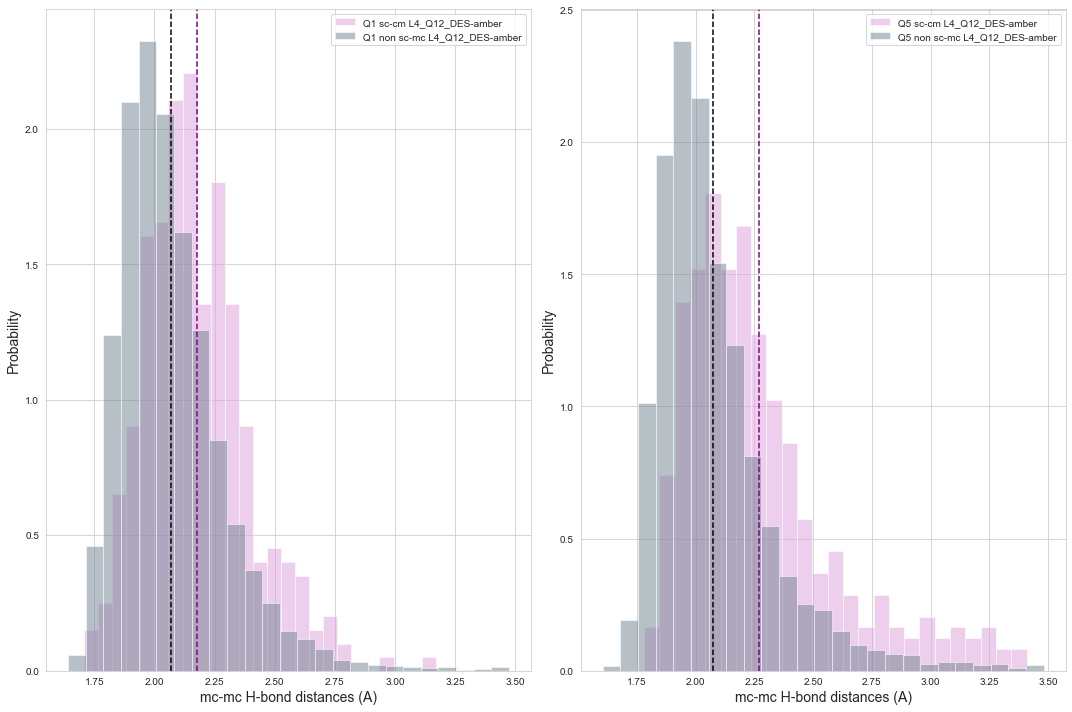

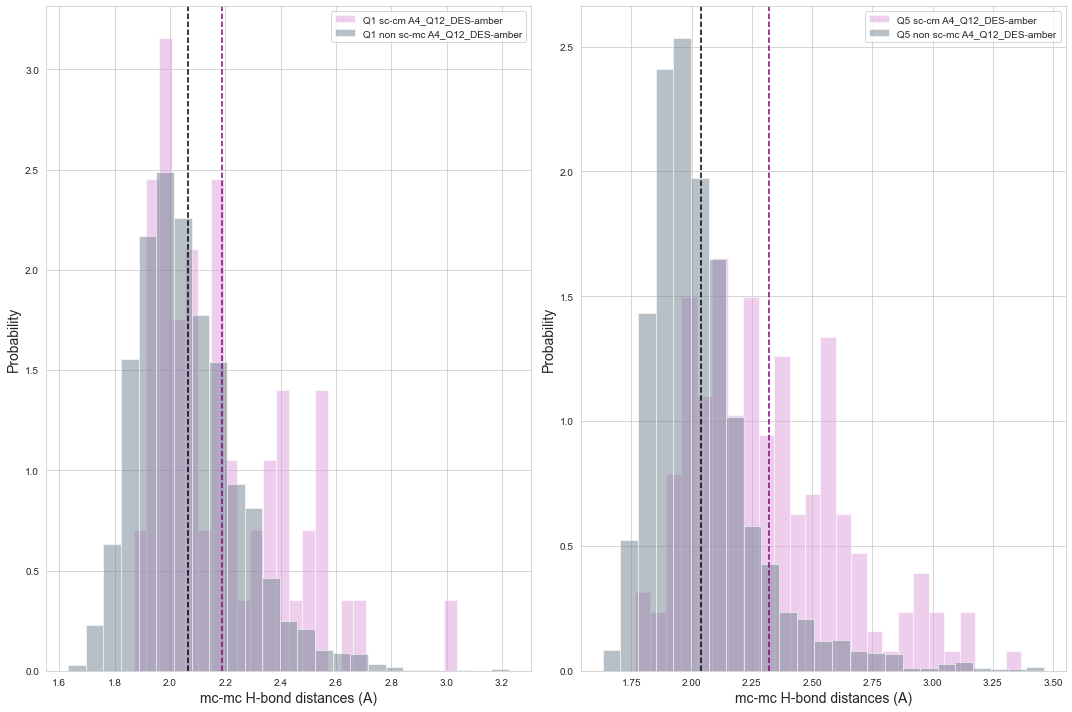

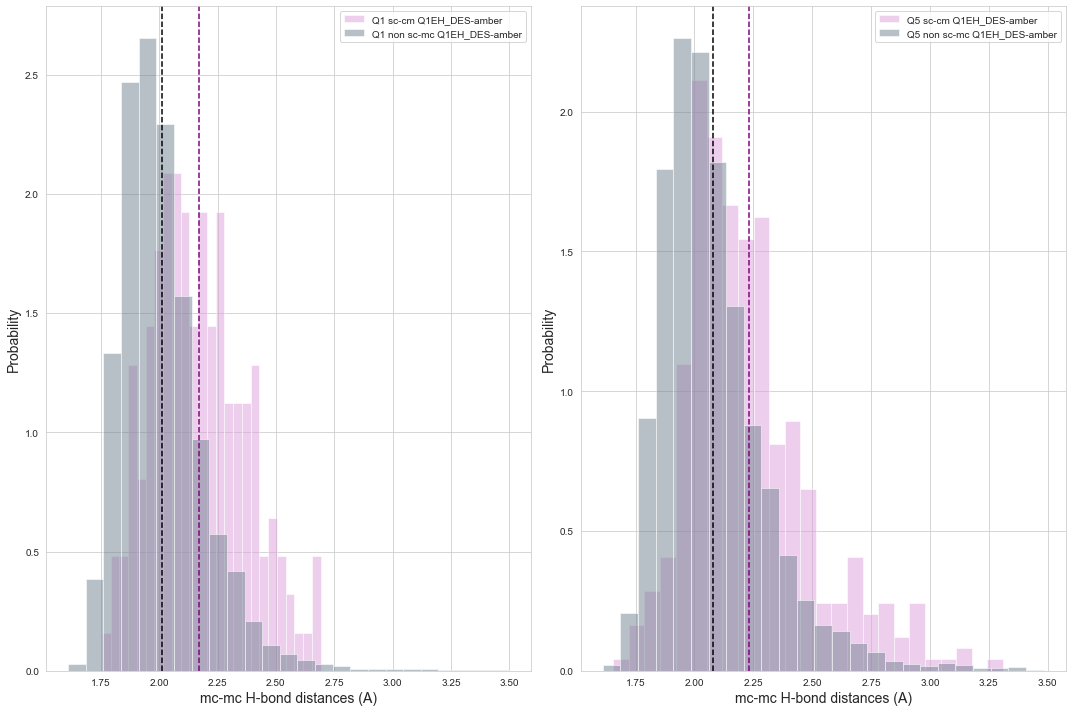

In [93]:
system_list = ('L4_Q12_DES-amber','A4_Q12_DES-amber','Q1EH_DES-amber')

t = {}
t_helix = {}
t_mcmc_hbond1 = {}
t_mcmc_hbond5 = {}
t_scmc_hbond1 = {}
t_scmc_hbond5 = {}
t_non_scmc_hbond1 = {}
t_non_scmc_hbond5 = {}
d_mcmc_helix1 = {}
d_mcmc_helix5 = {}
d_scmc_helix1 = {}
d_scmc_helix5 = {}
distance1_scmc = {}
distance5_scmc = {}
distance1_non_scmc = {}
distance5_non_scmc = {}
mean_scmc1={}
mean_scmc5={}
mean_non_scmc1={}
mean_non_scmc5={}

for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #first we have to read the trajectories 
    t[system] = read_trajectory(path, equil=0)
    print (system)
    #then we have to choose only the helical frames 
    t_helix[system] = helix_trajectory(t[system])
    print (t_helix[system])
    
    d_mcmc_helix1[system] = distance_mcmc_hbond1 (t_helix[system])
    #print(d_mcmc_helix1[system])
    d_mcmc_helix5[system] = distance_mcmc_hbond5 (t_helix[system])
    #print(d_mcmc_helix5[system])
    t_mcmc_hbond1[system],t_mcmc_hbond5[system] = mcmc_hbond_trajectory(t_helix[system],d_mcmc_helix1[system],d_mcmc_helix5[system])
    print(t_mcmc_hbond1[system],t_mcmc_hbond5[system])
    
    d_scmc_helix1[system] = distance_scmc_hbond1 (t_mcmc_hbond1[system])
    d_scmc_helix5[system] = distance_scmc_hbond5 (t_mcmc_hbond5[system])
    t_scmc_hbond1[system],t_scmc_hbond5[system]= scmc_hbond_trajectory(t_mcmc_hbond1[system],t_mcmc_hbond5[system],d_scmc_helix1[system], d_scmc_helix5[system])
    t_non_scmc_hbond1[system],t_non_scmc_hbond5[system]= non_scmc_hbond_trajectory(t_mcmc_hbond1[system],t_mcmc_hbond5[system],d_scmc_helix1[system], d_scmc_helix5[system])
    
    distance1_scmc[system] = distance_scmc1 (t_scmc_hbond1[system])
    mean_scmc1[system] = mean(distance1_scmc[system])
    distance5_scmc[system] = distance_scmc5 (t_scmc_hbond5[system])
    mean_scmc5[system] = mean(distance5_scmc[system])
    distance1_non_scmc[system] = distance_non_scmc1 (t_non_scmc_hbond1[system])
    mean_non_scmc1[system] = mean(distance1_non_scmc[system])
    distance5_non_scmc[system] = distance_non_scmc5 (t_non_scmc_hbond5[system])
    mean_non_scmc5[system] = mean(distance5_non_scmc[system])
    
    print (system)
    print ("    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc occurs is " + str(mean_scmc1[system]) + " Angstroms")
    print ("    The canonical Q1-Q5 H-bond distance average when the sc-mc occurs is " + str(mean_scmc5[system]) + " Angstroms")
    print ("    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc does not occur is " + str(mean_non_scmc1[system]) + " Angstroms")
    print ("    The canonical Q1-Q5 H-bond distance average when the sc-mc does not occur is " + str(mean_non_scmc5[system]) + " Angstroms")
    
    
    #Are there significance diferences between both distance averages? 
    #To check this we do a PERMUTATION TEST to compare it
    from mlxtend.evaluate import permutation_test
    p_value1 = permutation_test(distance1_scmc[system], distance1_non_scmc[system], method='approximate', num_rounds=1000, seed=0)
    print ("    The obtained Q1-(A/L)4 p_value is " + str(p_value1))
    p_value5 = permutation_test(distance5_scmc[system], distance5_non_scmc[system], method='approximate', num_rounds=1000, seed=0)
    print ("    The obtained Q1-Q5 p_value is " + str(p_value5))

    # the histogram of the data
    fig = plt.figure(figsize=(15,10))
    sns.set_style('whitegrid')
    
    plt.subplot(121)
    N, bins, patches = plt.hist(distance1_scmc[system], bins=25, facecolor= 'plum', density=True, label="Q1 sc-cm "+system, alpha=0.5)
    N, bins, patches = plt.hist(distance1_non_scmc[system], bins=25, facecolor= 'slategrey', density=True, label="Q1 non sc-mc "+system, alpha=0.5)
    plt.xlabel('mc-mc H-bond distances (A)', fontsize=14)
    plt.ylabel('Probability',fontsize=14)
    plt.axvline(mean_scmc1[system], color='purple', ls ='--')
    plt.axvline(mean_non_scmc1[system], color='k', ls ='--')
    #plt.title(r'Distance Histogram', fontsize=16)
    plt.legend()
    
    plt.subplot(122)
    N, bins, patches = plt.hist(distance5_scmc[system], bins=25, facecolor= 'plum', density=True, label="Q5 sc-cm "+system, alpha=0.5)
    N, bins, patches = plt.hist(distance5_non_scmc[system], bins=25, facecolor= 'slategrey', density=True, label="Q5 non sc-mc "+system, alpha=0.5)
    plt.xlabel('mc-mc H-bond distances (A)', fontsize=14)
    plt.ylabel('Probability',fontsize=14)
    plt.axvline(mean_scmc5[system], color='purple', ls ='--')
    plt.axvline(mean_non_scmc5[system], color='k', ls ='--')
    #plt.title(r'Distance Histogram', fontsize=16)
    plt.legend()
    
    fig.tight_layout()
    
    
    
    
    
    
    

L4_Q12_a99SB-disp
<mdtraj.Trajectory with 11116 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 11012 frames, 413 atoms, 24 residues, and unitcells> <mdtraj.Trajectory with 11024 frames, 413 atoms, 24 residues, and unitcells>
L4_Q12_a99SB-disp
    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc occurs is 2.218911 Angstroms
    The canonical Q1-Q5 H-bond distance average when the sc-mc occurs is 2.2099926 Angstroms
    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc does not occur is 2.012678 Angstroms
    The canonical Q1-Q5 H-bond distance average when the sc-mc does not occur is 2.0502431 Angstroms
    The obtained Q1-(A/L)4 p_value is 0.000999000999000999
    The obtained Q1-Q5 p_value is 0.000999000999000999


<ipython-input-118-c6cb7aae93f2>:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


A4_Q12_a99SB-disp
<mdtraj.Trajectory with 2803 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 2771 frames, 377 atoms, 24 residues, and unitcells> <mdtraj.Trajectory with 2790 frames, 377 atoms, 24 residues, and unitcells>
A4_Q12_a99SB-disp
    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc occurs is 2.156567 Angstroms
    The canonical Q1-Q5 H-bond distance average when the sc-mc occurs is 2.2031462 Angstroms
    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc does not occur is 2.0415244 Angstroms
    The canonical Q1-Q5 H-bond distance average when the sc-mc does not occur is 2.009974 Angstroms
    The obtained Q1-(A/L)4 p_value is 0.000999000999000999
    The obtained Q1-Q5 p_value is 0.000999000999000999
Q1EH_a99SB-disp
<mdtraj.Trajectory with 11555 frames, 412 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 11439 frames, 412 atoms, 24 residues, and unitcells> <mdtraj.Trajectory with 11515 frames, 412 atoms, 24 residu

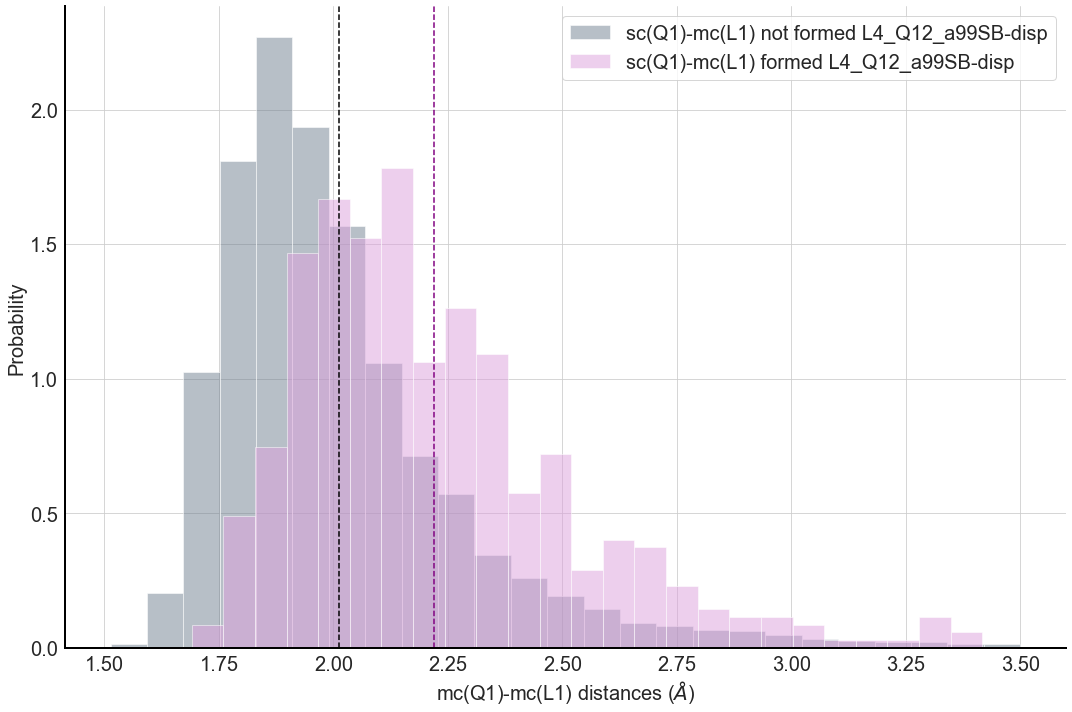

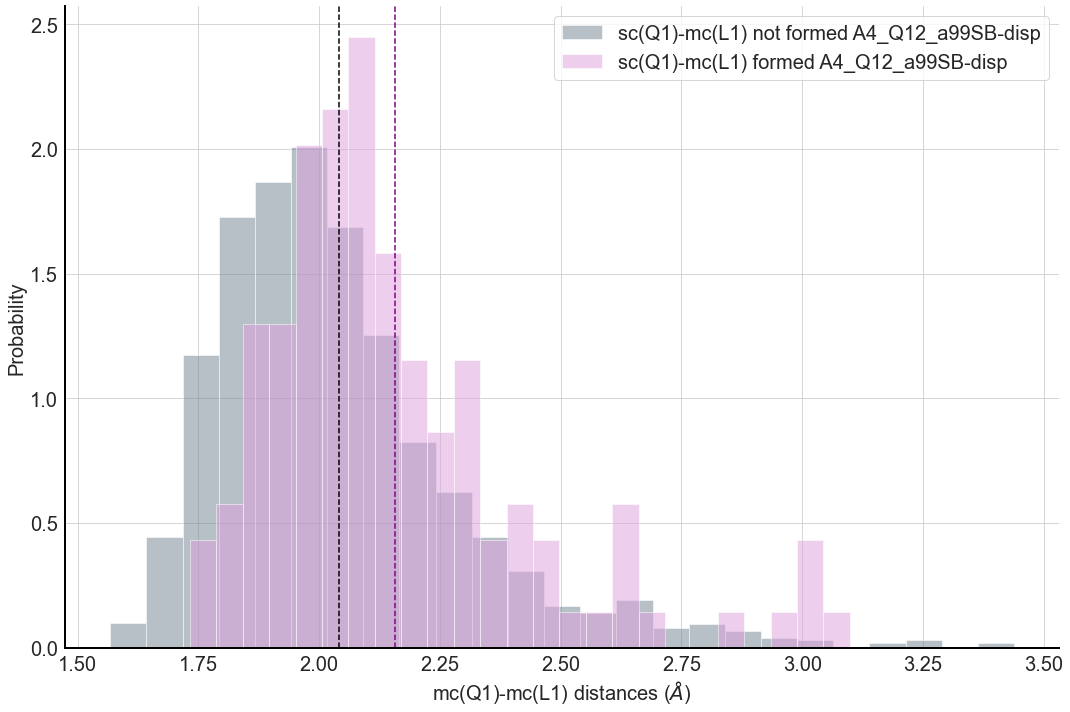

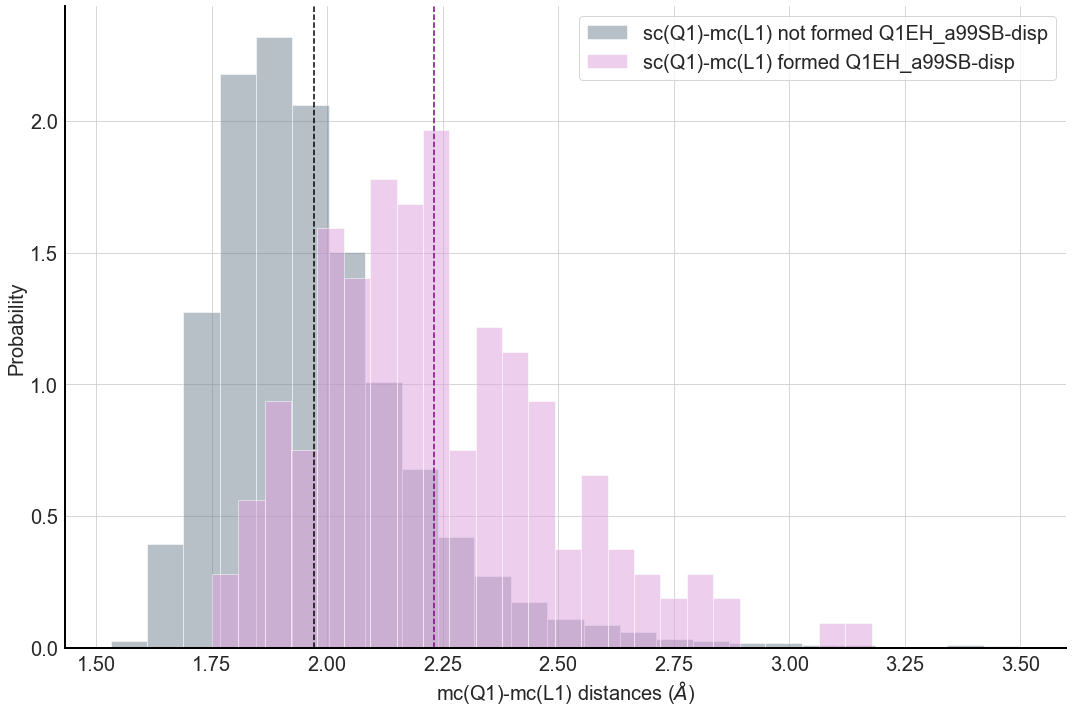

In [118]:
system_list = ('L4_Q12_a99SB-disp','A4_Q12_a99SB-disp','Q1EH_a99SB-disp')

t = {}
t_helix = {}
t_mcmc_hbond1 = {}
t_mcmc_hbond5 = {}
t_scmc_hbond1 = {}
t_scmc_hbond5 = {}
t_non_scmc_hbond1 = {}
t_non_scmc_hbond5 = {}
d_mcmc_helix1 = {}
d_mcmc_helix5 = {}
d_scmc_helix1 = {}
d_scmc_helix5 = {}
distance1_scmc = {}
distance5_scmc = {}
distance1_non_scmc = {}
distance5_non_scmc = {}
mean_scmc1={}
mean_scmc5={}
mean_non_scmc1={}
mean_non_scmc5={}

for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #first we have to read the trajectories 
    t[system] = read_trajectory(path, equil=0)
    print (system)
    #then we have to choose only the helical frames 
    t_helix[system] = helix_trajectory(t[system])
    print (t_helix[system])
    
    d_mcmc_helix1[system] = distance_mcmc_hbond1 (t_helix[system])
    #print(d_mcmc_helix1[system])
    d_mcmc_helix5[system] = distance_mcmc_hbond5 (t_helix[system])
    #print(d_mcmc_helix5[system])
    t_mcmc_hbond1[system],t_mcmc_hbond5[system] = mcmc_hbond_trajectory(t_helix[system],d_mcmc_helix1[system],d_mcmc_helix5[system])
    print(t_mcmc_hbond1[system],t_mcmc_hbond5[system])
    
    d_scmc_helix1[system] = distance_scmc_hbond1 (t_mcmc_hbond1[system])
    d_scmc_helix5[system] = distance_scmc_hbond5 (t_mcmc_hbond5[system])
    t_scmc_hbond1[system],t_scmc_hbond5[system]= scmc_hbond_trajectory(t_mcmc_hbond1[system],t_mcmc_hbond5[system],d_scmc_helix1[system], d_scmc_helix5[system])
    t_non_scmc_hbond1[system],t_non_scmc_hbond5[system]= non_scmc_hbond_trajectory(t_mcmc_hbond1[system],t_mcmc_hbond5[system],d_scmc_helix1[system], d_scmc_helix5[system])
    
    distance1_scmc[system] = distance_scmc1 (t_scmc_hbond1[system])
    mean_scmc1[system] = mean(distance1_scmc[system])
    distance5_scmc[system] = distance_scmc5 (t_scmc_hbond5[system])
    mean_scmc5[system] = mean(distance5_scmc[system])
    distance1_non_scmc[system] = distance_non_scmc1 (t_non_scmc_hbond1[system])
    mean_non_scmc1[system] = mean(distance1_non_scmc[system])
    distance5_non_scmc[system] = distance_non_scmc5 (t_non_scmc_hbond5[system])
    mean_non_scmc5[system] = mean(distance5_non_scmc[system])
    
    print (system)
    print ("    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc occurs is " + str(mean_scmc1[system]) + " Angstroms")
    print ("    The canonical Q1-Q5 H-bond distance average when the sc-mc occurs is " + str(mean_scmc5[system]) + " Angstroms")
    print ("    The canonical Q1-(L/A)4 H-bond distance average when the sc-mc does not occur is " + str(mean_non_scmc1[system]) + " Angstroms")
    print ("    The canonical Q1-Q5 H-bond distance average when the sc-mc does not occur is " + str(mean_non_scmc5[system]) + " Angstroms")
    
    
    #Are there significance diferences between both distance averages? 
    #To check this we do a PERMUTATION TEST to compare it
    from mlxtend.evaluate import permutation_test
    p_value1 = permutation_test(distance1_scmc[system], distance1_non_scmc[system], method='approximate', num_rounds=1000, seed=0)
    print ("    The obtained Q1-(A/L)4 p_value is " + str(p_value1))
    p_value5 = permutation_test(distance5_scmc[system], distance5_non_scmc[system], method='approximate', num_rounds=1000, seed=0)
    print ("    The obtained Q1-Q5 p_value is " + str(p_value5))

    # the histogram of the data
    fig = plt.figure(figsize=(15,10))
    sns.set_style('whitegrid')
    
    plt.subplot()
    N, bins, patches = plt.hist(distance1_non_scmc[system], bins=25, facecolor= 'slategrey', density=True, label="sc(Q1)-mc(L1) not formed "+system, alpha=0.5)
   
    N, bins, patches = plt.hist(distance1_scmc[system], bins=25, facecolor= 'plum', density=True, label="sc(Q1)-mc(L1) formed "+system, alpha=0.5)
    plt.xlabel('mc(Q1)-mc(L1) distances ($\AA$)', fontsize=20)
    plt.ylabel('Probability',fontsize=20)
    plt.axvline(mean_scmc1[system], color='purple', ls ='--')
    plt.axvline(mean_non_scmc1[system], color='k', ls ='--')
    #plt.title(r'Distance Histogram', fontsize=16)
    plt.legend(fontsize=20)
    
    ax = plt.axes()
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)

    ax.spines["bottom"].set_color("k")
    ax.spines["left"].set_color("k")
    ax.spines["right"].set_color("k")
    ax.spines["top"].set_color("k")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(labelsize=20)


    fig.tight_layout()
    fig.savefig(f"/home/lourdes/Documents/hbonddistri{system}.png")
    
    
    

<ipython-input-117-ce2c26912733>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


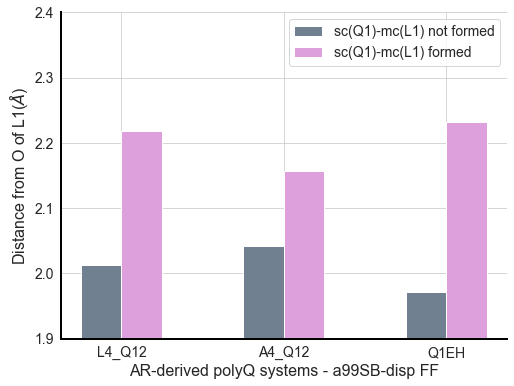

In [117]:
fig = plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = mean_non_scmc1.values()
 
# Choose the height of the cyan bars
bars2 = mean_scmc1.values()
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'slategrey', capsize=7, label='sc(Q1)-mc(L1) not formed')
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'plum', capsize=7, label='sc(Q1)-mc(L1) formed')

 
# general layout
plt.xticks([(r+barWidth/2) for r in range(3)], ['L4_Q12', 'A4_Q12', 'Q1EH'])
plt.legend(loc="upper right", fontsize=14)
plt.xlabel('AR-derived polyQ systems - a99SB-disp FF', fontsize=16)
plt.ylabel('Distance from O of L1($\AA$)', fontsize=16)

plt.ylim(1.9,2.4,0.001)
ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)

 
# Show graphic
plt.show()
fig.savefig("/home/lourdes/Documents/hbondcoop_a99SB-disp.png")

<ipython-input-70-7044170b5216>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


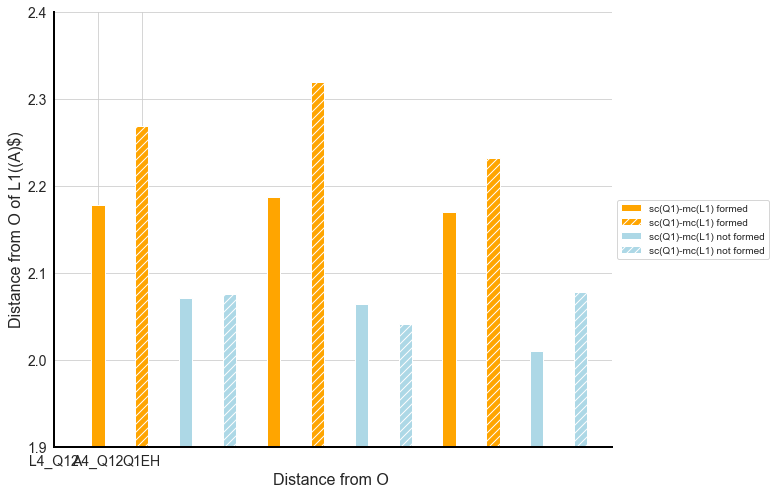

In [70]:
fig = plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')
# width of the bars
barWidth = 0.3
 
# Choose the height of the bars
bars1 = mean_scmc1.values()

bars2 = mean_non_scmc1.values()

bars3 = mean_scmc5.values()

bars4 = mean_non_scmc5.values()


 
r1 = [1,5,9]
r3 = [2,6,10]
r2 = [3,7,11]
r4 = [4,8,12]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'orange', capsize=7, label='sc(Q1)-mc(L1) formed')
plt.bar(r3, bars3, width = barWidth, color = 'orange', capsize=7, hatch='///',label='sc(Q1)-mc(L1) formed')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'lightblue', capsize=7, label='sc(Q1)-mc(L1) not formed')
plt.bar(r4, bars4, width = barWidth, color = 'lightblue', capsize=7, hatch='///',label='sc(Q1)-mc(L1) not formed')
 
# general layout
plt.xticks(np.arange(3), ['L4_Q12', 'A4_Q12', 'Q1EH'])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Distance from O ', fontsize=16)
plt.ylabel('Distance from O of L1((A)$)', fontsize=16)

plt.ylim(1.9,2.4,0.001)
ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)
 
# Show graphic
plt.show()